# Mudcard
- **Is determining the beta parameter in the f score purely up to description/intuition?**
    - it is usually based on some argument about the relative weights of false positives and false negatives
    - which error is worse and by how much?
- **Will we ever really use the confusion matrix or just the accuracy metrics that sklearn nicely gives us from the confusion matrix?**
- **What is the purpose of the confusion matrix if we have equations to help us figure out false/true postives/negatives for accuracy, recall and precision**
    - it is still a useful way to visualize the performance of your model
    - it's especially useful for multiclass classification problems where multiple versions of false negatives and false positives exist
    - it is pretty normal on technical interviews to ask about the confusion matrix
- **Can the confusion matrix and its metrics be applied to ordinal data?**
    - I'm not sure what you have in mind
    - come to my office hours to discuss
- **what kind of research question is expected for the project?**
    - classification or regression problem
- **How to determine p_crit? Is it usually 0.5?**
- **It was a bit unclear about when we would weight p_crit based on the beta value and how. Could you give a quick example next class?**
    - the example will be in PS6 :)
- **When deciding an optimal critical level for your probability, can you use the training data to decide that threshold?**
    - no, the training data should not be reused that way
    - you will see in PS6 how to select an optimal p_crit
- **Does it make sense to use multiple evaluation metrics at the same time? As in accuracy and precision together, recall and precision together, etc?**
- **Is it best to just use all of the metrics instead of just only choosing one?**
    - it's usually a good idea to calculate multiple metrics but the final model is usually based on optimizing over one metric
- **Is there always a trade-off between recall and precision?**
    - maximizing recall and precision simultaneously means that the overall accuracy of the model goes up which can be achieved by engineering better features, maybe trying out new ML models
    - the trade-off occurs when you try to tune p_crit for one classification model
    - as p_crit decreases, recall improves and precision goes down
    - as p_crit increases, precision improves and recall goes down
- **When should we use recall or precision instead of f scores?**
- **Will you go over "How to choose the metric" in more detail as we start use evaluation metrics for in class examples? Do you have other resources? The conditions on using different evaluation metrics seems a bit vague.**
    - it will be a team effort to chose a good evaluation metric because it depends a lot on stakeholders' priorities

## Evaluation metrics in supervised ML, part 2, predicted probabilities and regression metrics

By the end of this lecture, you will be able to
- Summarize the ROC and precision-recall curves, and the logloss metric
- Describe the most commonly used regression metrics


## <font color='LIGHTGRAY'> Evaluation metrics in supervised ML, part 2, predicted probabilities and regression</font>

<font color='LIGHTGRAY'>By the end of this lecture, you will be able to</font>
- **Summarize the ROC and precision-recall curves, and the logloss metric**
- <font color='LIGHTGRAY'>Describe the most commonly used regression metrics</font>


### The ROC curve
- Receiver Operating Characteristic
   - x axis: false positive rate (fpr = FP / (FP + TN))
   - y axis: true positive rate (R = TP / (TP + FN))
   - the curve shows fpr and R value pairs for various class 1 critical probabilities
- upper left corner: perfect predictor
- diagonal point: chance level predictions
- lower right corner: worst predictor

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
df = pd.read_csv('data/true_labels_pred_probs.csv')

y_true = df['y_true']
pred_prob_class1 = df['pred_prob_class1']
pred_prob_class0 = df['pred_prob_class0']

fpr = np.zeros(len(y_true))
tpr = np.zeros(len(y_true))

p_crits = np.sort(pred_prob_class1) # the sorted predicted probabilities serve as critical probabilities

for i in range(len(p_crits)):
    p_crit = p_crits[i]
    
    y_pred = np.zeros(len(y_true))
    y_pred[pred_prob_class1 <= p_crit] = 0
    y_pred[pred_prob_class1 > p_crit] = 1
    
    C = confusion_matrix(y_true,y_pred) 
    
    tpr[i] = C[1,1]/(C[1,0]+C[1,1])
    fpr[i] = C[0,1]/(C[0,0]+C[0,1])

from sklearn.metrics import roc_curve
# # the roc_curve function performs the same calculation
fpr,tpr,p_crits = roc_curve(y_true,pred_prob_class1)


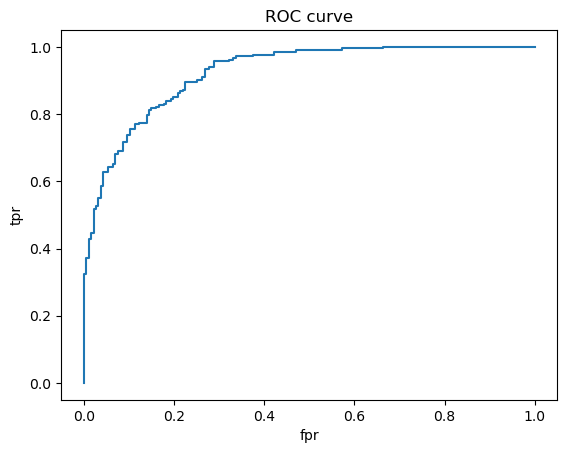

In [12]:
plt.plot(fpr,tpr)
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('ROC curve')
plt.show()

## Quiz 1
What's the (fpr,tpr) coordinate on the ROC curve if p_crit = 1?

## ROC AUC
- ROC is useful but it is not a single number metric
   - it cannot be directly used to compare various classification models
- summary statistics based on the ROC curve (for a complete list, see [here](https://en.wikipedia.org/wiki/Receiver_operating_characteristic#Further_interpretations))
- most commonly used metric is ROC AUC - ROC Area Under the Curve
   - AUC = 1 is a perfect classifier
   - AUC > 0.5 is above chance-level predictor
   - AUC = 0.5 is a chance-level classifier
   - AUC < 0.5 is a bad predictor
   - AUC = 0 classifies all points incorrectly

In [3]:
from sklearn.metrics import roc_auc_score
print(roc_auc_score(y_true,pred_prob_class1))

0.9236524315231854


## Precision-recall curve
- the drawback of ROC is that it uses TN, not good for imbalanced problems.
- the precision-recall curve doesn't use TN, ideal for imbalanced problems.

In [4]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score # the AUC of the P-R curve

p,r,p_crits = precision_recall_curve(y_true,pred_prob_class1)

print(average_precision_score(y_true,pred_prob_class1))

0.9315588971251672


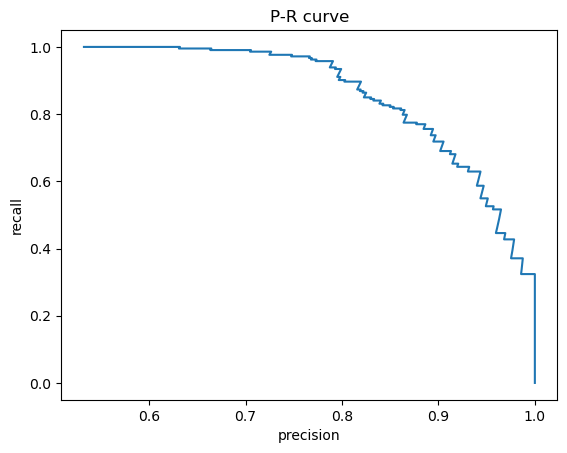

In [5]:
plt.plot(p,r)
plt.xlabel('precision')
plt.ylabel('recall')
plt.title('P-R curve')
plt.show()


## Quiz 2
What's the (p,r) coordinate on the curve if p_crit = 0?

## The logloss metric

### <center>$logloss = - \frac{1}{N}\sum (y_{true}\ln(p_{pred}) + (1-y_{true})\ln(1-p_{pred}))$</center>
- $p_{pred}$ is the predicted probability of the **positive class**
- the predicted probabilities are not converted into predicted classes
- excellent choice if you need accurate probabilities (e.g., when it is expensive/costly to act due to limited resources so you need to rank your points based on probabilities)
- two scenarios:
   - y_true = 0 - left term disappears
   - y_true = 1 - right term disappears
- log(0) is undefined
   - $p_{pred}$ is replaced with $\max(\min(p,1-10^{-15}),10^{-15})$ to avoid this issue

### The extreme cases
- the classifier is confidently wrong
   - $p_{pred} = 10^{-15}$ for points in class 1
   - $p_{pred} = 1 - 10^{-15}$ for points in class 0
<center>$logloss = -\frac{1}{N}\sum \ln(10^{-15}) = -\ln(10^{-15})$</center>
<center> $logloss \sim  34.5  $</center>

- the classifier is correct
   - $p_{pred} = 10^{-15}$ for points in class 0
   - $p_{pred} = 1 - 10^{-15}$ for points in class 1
<center>$logloss = -\frac{1}{N}\sum (1-0)(1-\ln(1-10^{-15})) = 10^{-15}$ for class 0</center>
<center>$logloss = -\frac{1}{N}\sum 1*\ln(1-10^{-15}) = 10^{-15}$ for class 1</center>
<center>$logloss \sim 0$</center>



In [6]:
from sklearn.metrics import log_loss
print(log_loss(y_true,pred_prob_class1))
help(log_loss)

0.3501519054532857
Help on function log_loss in module sklearn.metrics._classification:

log_loss(y_true, y_pred, *, eps=1e-15, normalize=True, sample_weight=None, labels=None)
    Log loss, aka logistic loss or cross-entropy loss.
    
    This is the loss function used in (multinomial) logistic regression
    and extensions of it such as neural networks, defined as the negative
    log-likelihood of a logistic model that returns ``y_pred`` probabilities
    for its training data ``y_true``.
    The log loss is only defined for two or more labels.
    For a single sample with true label :math:`y \in \{0,1\}` and
    a probability estimate :math:`p = \operatorname{Pr}(y = 1)`, the log
    loss is:
    
    .. math::
        L_{\log}(y, p) = -(y \log (p) + (1 - y) \log (1 - p))
    
    Read more in the :ref:`User Guide <log_loss>`.
    
    Parameters
    ----------
    y_true : array-like or label indicator matrix
        Ground truth (correct) labels for n_samples samples.
    
    y

## <font color='LIGHTGRAY'> Evaluation metrics in supervised ML, part 2, predicted probabilities and regression</font>

<font color='LIGHTGRAY'>By the end of this lecture, you will be able to</font>
- <font color='LIGHTGRAY'>Summarize the ROC and precision-recall curves, and the logloss metric</font>
- **Describe the most commonly used regression metrics**


## Regression metrics
- the target variable is continuous
- the predicted values are also continuous
- regression metrics measure some type of difference between y (true values) and y' (predicted values)

### Mean Squared Error 

### <center>$MSE(y,y') = \frac{1}{n}\sum_{i=1}^{n}(y_i-y_i')^2$</center>

<center><img src="figures/polifit_1.jpg" width="450"></center>

#### The unit of MSE is not the same as the target variable.

### Root Mean Square Error

### <center>$RMSE(y,y') = \sqrt{\frac{1}{n}\sum_{i=1}^{n}(y_i-y_i')^2}$</center>


### Mean Absolute Error

### <center>$MAE(y,y') = \frac{1}{n}\sum_{i=1}^{n}|y_i-y_i'|$</center>

#### Both RMSE and MAE have the same unit as the target variable.


## R2 score - coefficient of determination

### <center>$R^2(y,y') = 1 - \frac{\sum_{i=1}^{n}(y_i-y_i')^2}{\sum_{i=1}^{n}(y_i-\bar{y})^2}$,</center>
<center>where $\bar{y}$ is the mean of $y$.</center>

- R2 = 1 is the perfect regression model ($y == y'$)
- R2 = 0 is as good as a constant model that always predicts the expected value of y ($\bar{y}$)
- R2 < 0 is a bad regression model

#### R2 is dimensionless.

In [7]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

- RMSE is not implemented in sklearn, but you can calculate it as `np.sqrt(mean_squared_error(y_true,y_pred))`
- you can find more on regression metrics [here](https://scikit-learn.org/stable/modules/model_evaluation.html#regression-metrics)

## Quiz 3
Read in `data/reg_preds.csv`. It contains two columns: 

- y_true: value of owner-occupied homes in $1000's in Boston
- y_pred: predictions of a regression model

What's the ratio between the MSE and the variance of the home values? How does this ratio relate to the R2 score?

## Mudcard